# LASSO (Python)
Yang Xi <br>
14 Nov, 2018

# Example: Classification
**Notes:**
- In `sklearn.linear_model.LogisticRegression`, `C` is the inverse of regularization strength.<br>
- `Lasso` and `LassoCV` are not used, because they don't support sample/class weights
- We will use `GridSearchCV` with F1 score and balanced class weights

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

dfTrain0 = pd.read_csv("../../data/(2016 UCI) Credit Default/data_train.csv")
dfTest0 = pd.read_csv("../../data/(2016 UCI) Credit Default/data_test.csv")

def prepTrainTest(df):
    df = pd.get_dummies(df, columns=['Default', 'Sex', 'Marriage'], drop_first=True)
    df = pd.get_dummies(df, columns=['Education', 'SepRepayment']).drop(['Education_high school', 'SepRepayment_paid'], axis=1)
    return df
dfTrain = prepTrainTest(dfTrain0)
XTrain0 = dfTrain.drop('Default_1',axis=1)

scalerTrain = StandardScaler().fit(XTrain0)
XTrain = scalerTrain.transform(XTrain0)

yTrain = dfTrain['Default_1']

### Tune optimal `C` through cross-validation
To see progress, set `verbose=2`

Optimal C value = 0.014
CV f1 score with optimal C value = 0.518


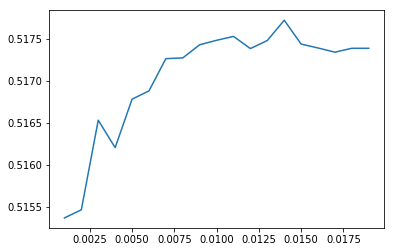

In [2]:
rangeC = np.arange(0.001, 0.02, 0.001).tolist()
lassoGS = GridSearchCV(LogisticRegression(penalty='l1', class_weight='balanced'),
                       param_grid = [{'C' : rangeC}],
                       scoring = make_scorer(f1_score, greater_is_better=True),
                       cv=10, verbose=0)
lassoGS.fit(XTrain, yTrain)

plt.plot(rangeC, lassoGS.cv_results_['mean_test_score'])
print('Optimal C value = {0:.3f}'.format(lassoGS.best_params_['C']))
print('CV f1 score with optimal C value = {0:.3f}'.format(lassoGS.best_score_))

### Model Interpretation
**Note:** the default coefficients values are fitted to predictors after standardization

In [3]:
lassoFit = lassoGS.best_estimator_
print('intercept = {0:.3f}'.format(lassoFit.intercept_[0]))
print(pd.DataFrame(lassoFit.coef_.T, index=XTrain0.columns, columns=['coef']))

intercept = -0.170
                            coef
CreditLimit            -0.240704
Age                     0.029909
SepBill                 0.000000
AugBill                 0.005790
SepPay                 -0.122660
AugPay                 -0.117560
Sex_M                   0.060993
Marriage_single        -0.068700
Education_graduate      0.000000
Education_university    0.000000
SepRepayment_1m delay   0.345389
SepRepayment_2m+ delay  0.767396


Restore the intercept and coefficient values to original scale for interpretation

In [4]:
orginCoef = lassoFit.coef_ / scalerTrain.scale_
orginIntercept = lassoFit.intercept_ - np.dot(orginCoef, scalerTrain.mean_)
print('orignal intercept = {0:.3f}'.format(orginIntercept[0]))
print(pd.DataFrame(orginCoef.T, index=XTrain0.columns, columns=['coef']))

orignal intercept = -0.273
                                coef
CreditLimit            -1.851516e-06
Age                     3.260531e-03
SepBill                 0.000000e+00
AugBill                 8.115462e-08
SepPay                 -7.730053e-06
AugPay                 -5.065440e-06
Sex_M                   1.245109e-01
Marriage_single        -1.378599e-01
Education_graduate      0.000000e+00
Education_university    0.000000e+00
SepRepayment_1m delay   1.050488e+00
SepRepayment_2m+ delay  2.496956e+00


### Train Performance

In [5]:
probTrain = [x[1] for x in lassoFit.predict_proba(XTrain)]
predTrain = lassoFit.predict(XTrain)

cmTrain = pd.DataFrame(confusion_matrix(yTrain, predTrain))
cmTrain.columns = pd.Series(cmTrain.columns).apply(lambda s: 'pred'+str(s))
cmTrain.index = pd.Series(cmTrain.index).apply(lambda s: 'actual'+str(s))
cmTrain

perfTrain = pd.DataFrame({'F1':[round(f1_score(yTrain, predTrain), 3)],
                          'AUC':[round(roc_auc_score(yTrain, probTrain),3)]})
print(perfTrain)

      F1    AUC
0  0.517  0.747


### Test performance

In [6]:
dfTest = prepTrainTest(dfTest0)
XTest = scalerTrain.transform(dfTest.drop('Default_1',axis=1))
yTest = dfTest['Default_1']
    
predTest = lassoFit.predict(XTest)

cmTest = pd.DataFrame(confusion_matrix(yTest, predTest))
cmTest.columns = pd.Series(cmTest.columns).apply(lambda s: 'pred'+str(s))
cmTest.index = pd.Series(cmTest.index).apply(lambda s: 'actual'+str(s))
cmTest

f1Test = f1_score(yTest, predTest)
print('Test f1 score = {0:.3f}'.format(f1Test))


Test f1 score = 0.508
